In [1]:
#подключаем библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
#настройки графиков
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(15,6)}
        )

In [3]:
#подключаемся к кликхаусу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240720'
}

q = """
SELECT user_id, exp_group, countIf(user_id, action = 'like') as likes, countIf(user_id, action = 'view') as views
FROM simulator_20240720.feed_actions 
WHERE toDate(time) >= toDate('2024-06-28') and toDate(time) <= toDate('2024-07-04') and exp_group in (0,1,2,3)
group by user_id, exp_group
"""

# Вытащили пользователей
users_df = ph.read_clickhouse(q, connection=connection)

In [4]:
#считаем обычный CTR
users_df['ctr'] = users_df.likes / users_df.views

In [6]:
#разобъем группы на тест и контроль
test1 = users_df[users_df.exp_group == 3]
control1 = users_df[users_df.exp_group == 0]

test2 = users_df[users_df.exp_group == 2]
control2 = users_df[users_df.exp_group == 1]

In [10]:
test1.head()

,user_id,exp_group,likes,views,ctr,linearized_likes
0,115383,3,12,44,0.272727,2.767128
2,123580,3,2,11,0.181818,-0.308218
8,118359,3,7,38,0.184211,-0.973844
12,16699,3,6,16,0.375000,2.642592
13,138445,3,18,93,0.193548,-1.514933


In [8]:
#посчитаем глобальный CTR в контроле
ctr_control1 = control1.likes.sum() / control1.views.sum()
ctr_control2 = control2.likes.sum() / control2.views.sum()

<Axes: xlabel='ctr', ylabel='Count'>

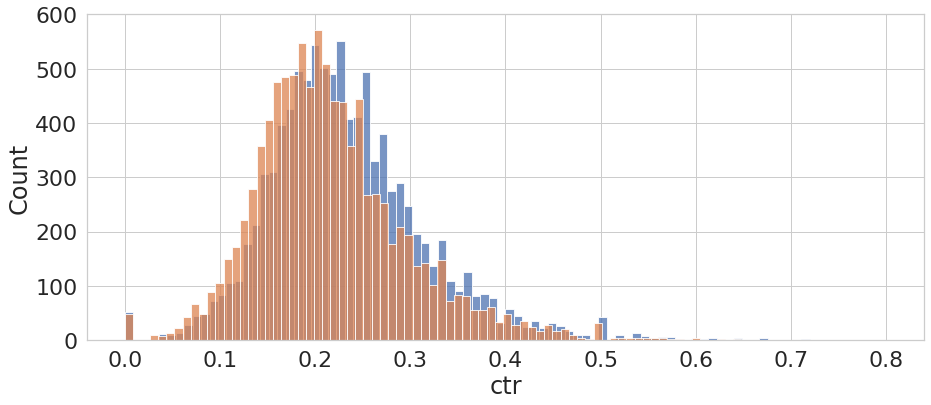

In [24]:
sns.histplot(test1.ctr)
sns.histplot(control1.ctr)

<Axes: xlabel='linearized_likes', ylabel='Count'>

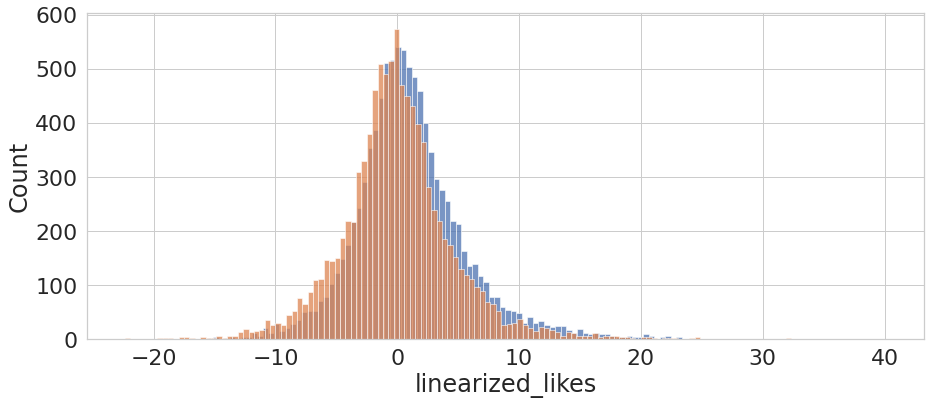

In [28]:
sns.histplot(test1.linearized_likes)
sns.histplot(control1.linearized_likes)

In [9]:
# расчет линеаризованных лайков
test1 = test1.assign(linearized_likes = lambda x: x.likes - ctr_control1 * x.views)
control1 = control1.assign(linearized_likes = lambda x: x.likes - ctr_control1 * x.views)

test2 = test2.assign(linearized_likes = lambda x: x.likes - ctr_control2 * x.views)
control2 = control2.assign(linearized_likes = lambda x: x.likes - ctr_control2 * x.views)

In [35]:
#проверим требование на гомогенность дисперсий для уточнения параметра в t-тесте
stats.levene(test1.linearized_likes, control1.linearized_likes, center='median')

LeveneResult(statistic=0.13576527402423189, pvalue=0.7125316496454377)

Требование выполняется

In [36]:
#сравним t-тестом линеаризованные лайки
linear_t1 = stats.ttest_ind(test1.linearized_likes, control1.linearized_likes, equal_var=True)
linear_t1

Ttest_indResult(statistic=16.186959394183784, pvalue=1.4740034890835593e-58)

In [37]:
#проверим требование на гомогенность дисперсий
stats.levene(test1.ctr, control1.ctr, center='median')

LeveneResult(statistic=5.031261726895506, pvalue=0.02490470490440779)

In [38]:
#сравним t-тестом обычные CTR
ctr_t1 = stats.ttest_ind(test1.ctr, control1.ctr, equal_var=False)
ctr_t1

Ttest_indResult(statistic=13.935320516755777, pvalue=6.216047483061785e-44)

In [39]:
linear_t1[1] < ctr_t1[1]

True

P-value уменьшилось при переходе от CTR к линеаризованным лайкам

In [54]:
#Манн-Уитни также видит различие
stats.mannwhitneyu(test1.linearized_likes, control1.linearized_likes, alternative = 'two-sided')

MannwhitneyuResult(statistic=56537890.0, pvalue=2.504376811309453e-65)

In [55]:
#посмотрим в какую сторону
A_gt_B = 0
n = 10000
for _ in range(n):
    A_gt_B+= test1.linearized_likes.sample().values[0] > control1.linearized_likes.sample().values[0]
    
print('В', f"{A_gt_B/n:.1%}", 'случаев linearized_likes в тесте > чем в контроле')

В 56.4% случаев linearized_likes в тесте > чем в контроле


Перейдем к сравнению 1 и 2 групп.

<Axes: xlabel='linearized_likes', ylabel='Count'>

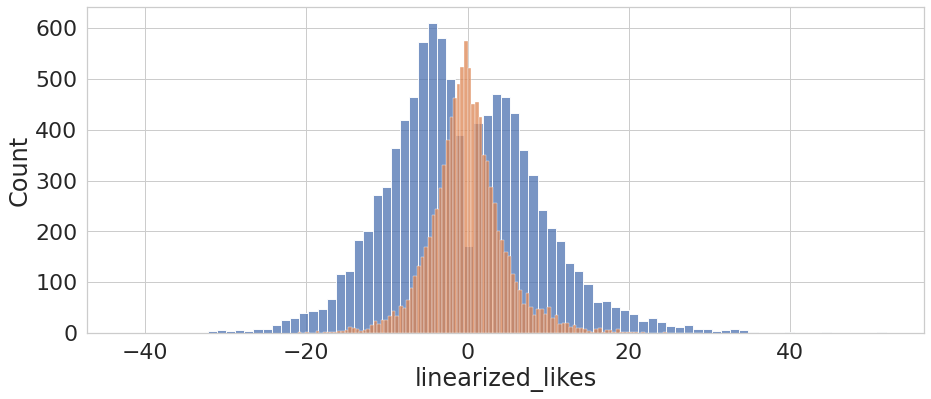

In [42]:
#визуализируем наши метрики
sns.histplot(test2.linearized_likes)
sns.histplot(control2.linearized_likes)

In [45]:
#проверим требование на гомогенность дисперсий
stats.levene(test2.linearized_likes, control2.linearized_likes, center='median')

LeveneResult(statistic=3535.1569451708956, pvalue=0.0)

In [46]:
#t-тест видит различие
linear_t2 = stats.ttest_ind(test2.linearized_likes, control2.linearized_likes, equal_var=False)
linear_t2

Ttest_indResult(statistic=-5.936377101934478, pvalue=2.9805064038668383e-09)

In [60]:
#при этом среднее значение linearized_likes в тесте уменьшилось
test2.linearized_likes.mean() > control2.linearized_likes.mean()

False

In [47]:
#при сравнении обычных ctr высокое значение p value не позволяет нам отклонить нулевую гипотезу
ctr_t2 = stats.ttest_ind(test2.ctr, control2.ctr, equal_var=False)
ctr_t2

Ttest_indResult(statistic=-0.4051491913112924, pvalue=0.6853733311407387)

In [48]:
linear_t2[1] < ctr_t2[1]

True

P-value также уменьшилось при переходе от CTR к линеаризованным лайкам

In [51]:
#Манн-Уитни также видит различие
stats.mannwhitneyu(test2.linearized_likes, control2.linearized_likes, alternative = 'two-sided')

MannwhitneyuResult(statistic=45451097.5, pvalue=2.4030320776345276e-23)

In [53]:
#посмотрим в какую сторону
A_gt_B = 0
n = 10000
for _ in range(n):
    A_gt_B+= test2.linearized_likes.sample().values[0] > control2.linearized_likes.sample().values[0]
    
print('В', f"{A_gt_B/n:.1%}", 'случаев linearized_likes в тесте > чем в контроле')

В 45.6% случаев linearized_likes в тесте > чем в контроле


Итого:
    
1. При сравнении 0 и 3 группы различие есть как по метрике обычного CTR таки по линеаризованным лайкам. В тестовой группе (3) обе метрики увеличились.
   При этом в сравнении t-тестом p-value в случае лиаризованных лайком стало меньше, чем при обычном CTR.

2. В сравнении 1 и 2 группы переход к метрике линеаризованных лайков уменьшил наш p-value в t-тесте таким образом, что тест прокрасился. В тестовой группе (2) значение метрики уменьшилось.
   Но при переходе к метрике линеаризованных лайков у нас по прежнему не выполняется требование на гомогенность дисперсий, поэтому t-тест в этом кейсе проводить нужно с осторожностью.